#### movilenetv2
#### https://www.tensorflow.org/tutorials/images/transfer_learning?hl=es-419

In [1]:
import tensorflow as tf
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### funciones

In [3]:
def model_info(model, verbose=0):
    layer_info = []
    header = ["Number", "Name", "Input_shape", "Output_shape", "Trainable"]
    data = [[]]
    trainable_layers, non_trainable_layers = 0, 0
    trainable_params, non_trainable_params = 0, 0
    for i, layer in enumerate(model.layers):
        layer_name = layer.name
        input_shape = layer.input_shape[1:]
        output_shape = layer.output_shape[1:]
        trainable = layer.trainable
        layer_type = type(layer).__name__
        data.append([i + 1, layer_type if layer_type != "Functional" else layer.name, input_shape, output_shape, trainable])
        layer_params = np.sum([np.prod(p.shape) for p in layer.weights])
        if trainable:
            trainable_params += layer_params
            trainable_layers += 1
        else:
            non_trainable_params += layer_params
            non_trainable_layers += 1
    print("=========================================================")
    print(f"Total params: {int(trainable_params + non_trainable_params):,}")
    print(f"Trainable params: {int(trainable_params):,}")
    print(f"Non-trainable params: {int(non_trainable_params):,}")
    print(f"Total layers: {len(model.layers):,}")
    print(f"Trainable layers: {trainable_layers:,}")
    print(f"Non-trainable params: {non_trainable_layers:,}")
    print("=========================================================")
    if verbose == 1:
        print(tabulate(data, headers=header, colalign="c", tablefmt="github"))

In [4]:
def get_history_stats(history):
    print(f"Accuracy: {max(history['accuracy']):.{4}f}")
    print(f"Validation accuracy: {max(history['val_accuracy']):.{4}f}")
    print(f"Loss: {min(history['loss']):.{4}f}")
    print(f"Validation loss : {min(history['val_loss']):.{4}f}")    

In [5]:
def plot_total_hist(history1, history2, fine_tunning_epoch):
    initial_epochs = fine_tunning_epoch
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history1["accuracy"] + history2["accuracy"], label='Training Accuracy')
    plt.plot(history1["val_accuracy"] + history2["val_accuracy"], label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(history1["loss"] + history2["loss"], label='Training Loss')
    plt.plot(history1["val_loss"] + history2["val_loss"], label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [36]:
def plot_hist(history):
    plt.figure(figsize=(7, 7))
    plt.subplot(2, 1, 1)
    plt.plot(history["accuracy"], label='Training Accuracy')
    plt.plot(history["val_accuracy"], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0.5,1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(history["loss"], label='Training Loss')
    plt.plot(history["val_loss"], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [50]:
PATH = "/content/drive/MyDrive/Datasets/data"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

#### cargando datos

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2637 files belonging to 2 classes.
Found 660 files belonging to 2 classes.


In [10]:
callbacks_path = "/content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/mobilenet_models/"
model_name = callbacks_path + "best_model.h5"
fine_model_name = callbacks_path + "best_model_fine.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")
fine_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=fine_model_name, 
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      verbose=1,
                                                      mode="max")

#### data augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2)
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 0s 0us/step


In [13]:
base_model.trainable = False

#### agregado propias capas

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 5e-4

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [19]:
model_info(model, verbose=1)

Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
Total layers: 8
Trainable layers: 7
Non-trainable params: 1
|   Number | Name                   | Input_shape   | Output_shape   | Trainable   |
|----------|------------------------|---------------|----------------|-------------|
|          |                        |               |                |             |
| 1        | InputLayer             | []            | []             | True        |
| 2        | Sequential             | (224, 224, 3) | (224, 224, 3)  | True        |
| 3        | TFOpLambda             | (224, 224, 3) | (224, 224, 3)  | True        |
| 4        | TFOpLambda             | (224, 224, 3) | (224, 224, 3)  | True        |
| 5        | mobilenetv2_1.00_224   | (224, 224, 3) | (7, 7, 1280)   | False       |
| 6        | GlobalAveragePooling2D | (7, 7, 1280)  | (1280,)        | True        |
| 7        | Dropout                | (1280,)       | (1280,)        | True        |
| 8       

In [20]:
initial_epochs = 20
history = model.fit(train_dataset, 
                    epochs=initial_epochs, 
                    validation_data=validation_dataset,
                    callbacks=[model_checkpoint])

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.6462
Epoch 1: val_accuracy improved from -inf to 0.78182, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/mobilenet_models/best_model.h5
83/83 [==============================] - 321s 3s/step - loss: 0.6298 - accuracy: 0.6462 - val_loss: 0.4679 - val_accuracy: 0.7818
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.7710
Epoch 2: val_accuracy improved from 0.78182 to 0.81515, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importatntes/mobilenet_models/best_model.h5
83/83 [==============================] - 10s 114ms/step - loss: 0.4751 - accuracy: 0.7710 - val_loss: 0.4132 - val_accuracy: 0.8152
Epoch 3/20
82/83 [============================>.] - ETA: 0s - loss: 0.4337 - accuracy: 0.8018
Epoch 3: val_accuracy improved from 0.81515 to 0.82121, saving model to /content/drive/MyDrive/Colab Notebooks/Notebooks_importat

In [21]:
print(history.history)

{'loss': [0.6297513842582703, 0.47514578700065613, 0.43311795592308044, 0.410614937543869, 0.39307940006256104, 0.39045408368110657, 0.3821351230144501, 0.3699621558189392, 0.3677833676338196, 0.3500378727912903, 0.35033226013183594, 0.3563965857028961, 0.34768372774124146, 0.34174320101737976, 0.3373694121837616, 0.3402285873889923, 0.32023918628692627, 0.33534249663352966, 0.32565560936927795, 0.32504770159721375], 'accuracy': [0.6461888551712036, 0.7709518671035767, 0.8024269938468933, 0.8062191605567932, 0.8251801133155823, 0.8255593180656433, 0.8285930752754211, 0.8320060968399048, 0.8388320207595825, 0.8452787399291992, 0.8475540280342102, 0.8445202708244324, 0.8441410660743713, 0.8475540280342102, 0.8479332327842712, 0.8437618613243103, 0.8543799519538879, 0.850208580493927, 0.8604474663734436, 0.8536215424537659], 'val_loss': [0.46785637736320496, 0.41316699981689453, 0.39131760597229004, 0.37882208824157715, 0.3664323091506958, 0.37135228514671326, 0.355869859457016, 0.3500717

## ajuste fino


In [22]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [37]:
fine_layer_unfrize = 20

In [38]:
for i, layer in enumerate(base_model.layers[:-fine_layer_unfrize]):
    layer.trainable = False
for i, layer in enumerate(base_model.layers[-fine_layer_unfrize:]):
        if isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.AveragePooling2D):
            layer.trainable = False

In [39]:
model_info(base_model, verbose=1)

Total params: 2,257,984
Trainable params: 1,032,640
Non-trainable params: 1,225,344
Total layers: 154
Trainable layers: 10
Non-trainable params: 144
|   Number | Name               | Input_shape          | Output_shape   | Trainable   |
|----------|--------------------|----------------------|----------------|-------------|
|          |                    |                      |                |             |
| 1        | InputLayer         | []                   | []             | False       |
| 2        | Conv2D             | (224, 224, 3)        | (112, 112, 32) | False       |
| 3        | BatchNormalization | (112, 112, 32)       | (112, 112, 32) | False       |
| 4        | ReLU               | (112, 112, 32)       | (112, 112, 32) | False       |
| 5        | DepthwiseConv2D    | (112, 112, 32)       | (112, 112, 32) | False       |
| 6        | BatchNormalization | (112, 112, 32)       | (112, 112, 32) | False       |
| 7        | ReLU               | (112, 112, 32)       | (1

In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [42]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs
fine_history = model.fit(train_dataset,
                        validation_data = validation_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1], 
                         callbacks=[fine_model_checkpoint])

Epoch 20/40
82/83 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9200
Epoch 20: val_accuracy did not improve from 0.86515
83/83 [==============================] - 14s 105ms/step - loss: 0.1954 - accuracy: 0.9200 - val_loss: 0.3215 - val_accuracy: 0.8470
Epoch 21/40
83/83 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.9367
Epoch 21: val_accuracy did not improve from 0.86515
83/83 [==============================] - 10s 110ms/step - loss: 0.1667 - accuracy: 0.9367 - val_loss: 0.3167 - val_accuracy: 0.8470
Epoch 22/40
82/83 [============================>.] - ETA: 0s - loss: 0.1730 - accuracy: 0.9276
Epoch 22: val_accuracy did not improve from 0.86515
83/83 [==============================] - 10s 109ms/step - loss: 0.1727 - accuracy: 0.9276 - val_loss: 0.3463 - val_accuracy: 0.8364
Epoch 23/40
82/83 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9318
Epoch 23: val_accuracy did not improve from 0.86515
83/83 [=========

In [43]:
print(history.history)

{'loss': [0.6297513842582703, 0.47514578700065613, 0.43311795592308044, 0.410614937543869, 0.39307940006256104, 0.39045408368110657, 0.3821351230144501, 0.3699621558189392, 0.3677833676338196, 0.3500378727912903, 0.35033226013183594, 0.3563965857028961, 0.34768372774124146, 0.34174320101737976, 0.3373694121837616, 0.3402285873889923, 0.32023918628692627, 0.33534249663352966, 0.32565560936927795, 0.32504770159721375], 'accuracy': [0.6461888551712036, 0.7709518671035767, 0.8024269938468933, 0.8062191605567932, 0.8251801133155823, 0.8255593180656433, 0.8285930752754211, 0.8320060968399048, 0.8388320207595825, 0.8452787399291992, 0.8475540280342102, 0.8445202708244324, 0.8441410660743713, 0.8475540280342102, 0.8479332327842712, 0.8437618613243103, 0.8543799519538879, 0.850208580493927, 0.8604474663734436, 0.8536215424537659], 'val_loss': [0.46785637736320496, 0.41316699981689453, 0.39131760597229004, 0.37882208824157715, 0.3664323091506958, 0.37135228514671326, 0.355869859457016, 0.3500717

In [44]:
print(fine_history.history)

{'loss': [0.19537320733070374, 0.1666654348373413, 0.17268231511116028, 0.16935473680496216, 0.15453442931175232, 0.1635408252477646, 0.15500161051750183, 0.14590255916118622, 0.14595772325992584, 0.14820243418216705, 0.14343290030956268, 0.1347338855266571, 0.13899418711662292, 0.12524794042110443, 0.12340795993804932, 0.12881684303283691, 0.12257110327482224, 0.11342040449380875, 0.1141267865896225, 0.11800379306077957, 0.11250059306621552], 'accuracy': [0.9199848175048828, 0.9366704821586609, 0.9275692105293274, 0.9317406415939331, 0.9408418536186218, 0.9328782558441162, 0.9381873607635498, 0.9381873607635498, 0.9389457702636719, 0.9393249750137329, 0.9434964060783386, 0.9446340799331665, 0.9461509585380554, 0.9491846561431885, 0.9541144967079163, 0.9503223299980164, 0.9533560872077942, 0.9544937610626221, 0.9552521705627441, 0.9556313753128052, 0.9552521705627441], 'val_loss': [0.3214733302593231, 0.3167058229446411, 0.34630343317985535, 0.3509521782398224, 0.3371351957321167, 0.36

In [45]:
get_history_stats(history.history)

Accuracy: 0.8604
Validation accuracy: 0.8636
Loss: 0.3202
Validation loss : 0.3284


In [46]:
get_history_stats(fine_history.history)

Accuracy: 0.9556
Validation accuracy: 0.8833
Loss: 0.1125
Validation loss : 0.2958


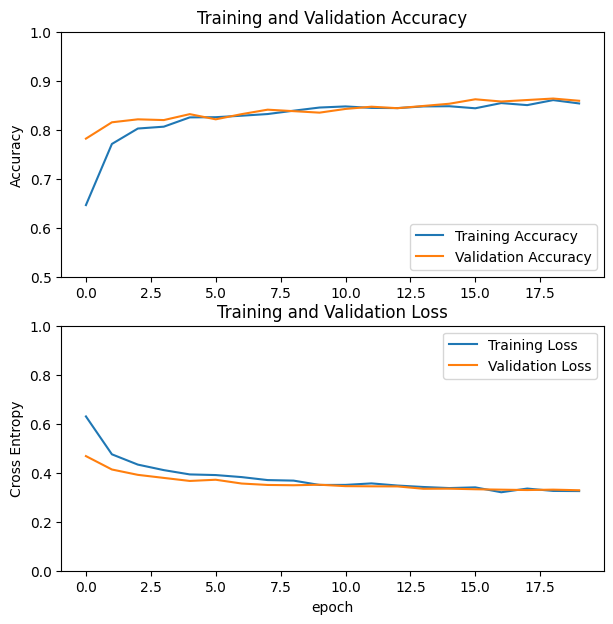

In [47]:
plot_hist(history.history)

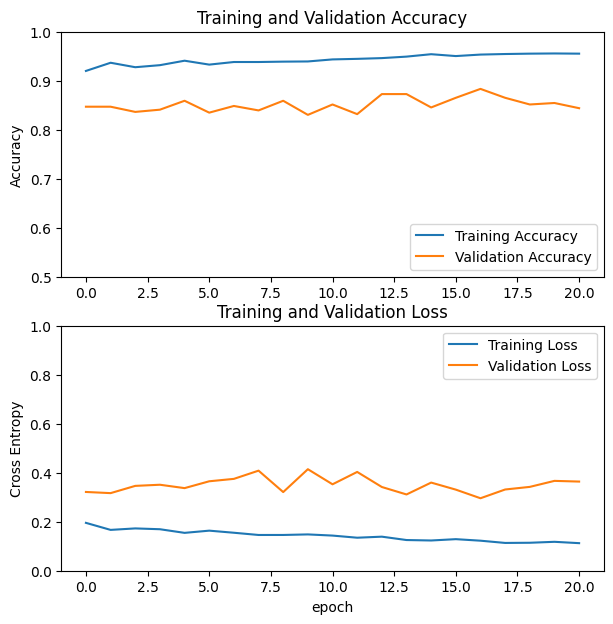

In [48]:
plot_hist(fine_history.history)

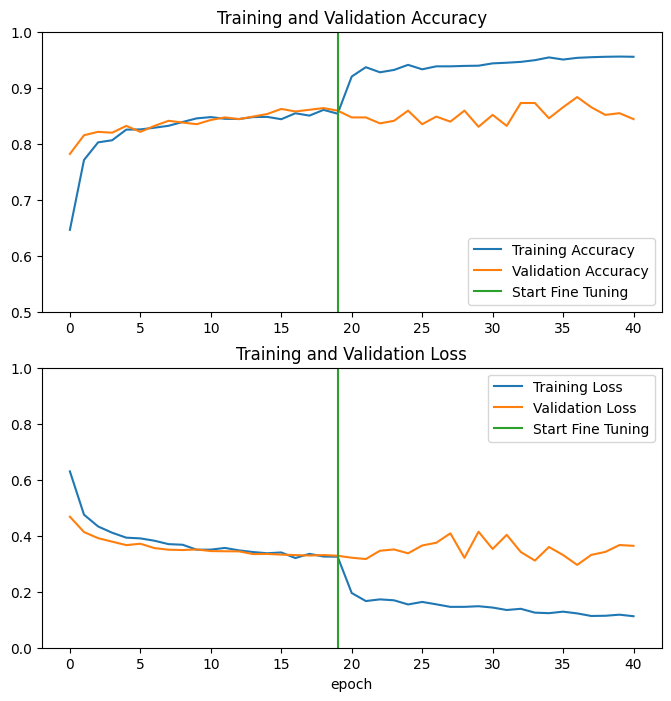

In [49]:
plot_total_hist(history.history, fine_history.history, fine_tune_epochs)